In [1]:
%matplotlib inline
from skimage import feature
from math import sqrt
from skimage.morphology import disk, opening
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show, axes, sci
from matplotlib import colors
from thunder import NMF, PCA, RegressionModel, Colorize
import numpy as np
from numpy import genfromtxt
from pyfnnd import apply_all_cells
import scipy.io
from scipy.stats import pearsonr
import math
import itertools
import glob, os
image = Colorize.image
from scipy import signal
from subprocess import Popen, PIPE
import PIL
window = signal.gaussian(5, std=1)
sns.set_context('notebook')
sns.set_style('ticks')
plt.ioff()


def Spikeinference(img,Mask):
    MeanFluo_ROI=img.meanByRegions(Mask).collectAsArray()
    n_hat, C_hat, LL, theta_hat=apply_all_cells(np.transpose(MeanFluo_ROI[1][:,0]),disp=0, n_jobs=-1)
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-ROI_SpikePred.mat', mdict={'n_hat':n_hat,'C_hat':C_hat,'LL':LL,'theta_hat':theta_hat}, oned_as='column', do_compression='true')
    np.savetxt('/mnt/downloads/'+savedirectory+'/'+filename+'-segmentation-ROI_Raw.csv',MeanFluo_ROI[1][:,0])
    return n_hat, C_hat, LL, theta_hat

def NMFCorr(stimparam,NMFH,data_to_analyze,p_value=0.05):
    results=[]
    lst = np.asarray(list(itertools.product([0, 1], repeat=stimparam.shape[0])))
    corrMat=np.zeros((Mask.shape[0],Mask.shape[1]),dtype=np.float32)
    for k in range(0,NMFH.shape[0]):
        result=[]
        ccr=[]
        pvalues=[]
        for j in range(1,lst.shape[0]):
            combination=np.zeros((1,NMFH.shape[1]),dtype=np.int16);
            for i in np.transpose(np.nonzero(lst[j])[0]):
                combination+=stimparam[i]
            cc,pval=pearsonr(NMFH[k,:],combination[0])
            ccr.append(cc)
            pvalues.append(pval)
        result.append(ccr[np.argmin(pvalues)])
        result.append(pvalues[np.argmin(pvalues)])
        result.append(lst[np.argmin(pvalues)])
        results.append(result)
        combination=np.zeros((1,NMFH.shape[1]),dtype=np.int16);
        if pvalues[np.argmin(pvalues)]<p_value:
            for i in np.transpose(np.nonzero(lst[np.argmin(pvalues)])[0]):
                combination+=stimparam[i]  
            corrs = data_to_analyze.correlate(combination)
            corrMat = corrs.collectValuesAsArray()
            Masktemp=Mask.astype(np.float32).copy()
            for idx in xrange(0,corrMat.shape[0]):
                Masktemp[Masktemp==idx+1]=corrMat[idx]
            fig = figure(dpi=300)
            plt.imshow(Masktemp)
            plt.savefig('/mnt/downloads/'+savedirectory+'/'+filename+'-Correlation of significant NMF-'+str(k)+' combination.png', dpi=300, bbox_inches='tight')
            scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-Correlation of significant NMF-'+str(k)+'.mat', mdict={'correlations':corrMat}, oned_as='column', do_compression='true')
            plt.close("all")
    with open('/mnt/downloads/'+savedirectory+'/'+filename+'-NMF_Spikes_CorrCoef.txt', 'a') as outfile:
        i=0
        for data_slice in results:
            outfile.write ('NMF-'+str(i)+' CorrCoef : ' + np.array_str(data_slice[0]).rjust(10)+'p-value : '+ np.array_str(data_slice[1]) +'Combination of features : '+ np.array_str(data_slice[2]))
            outfile.write('\n')
            i+=1
    return

def NMF_spikes(n_hat,stimparam,numcomp=18):
    global data_to_analyze
    global model
    np.save('/mnt/downloads/'+directory+'/nhatFullData.npy',n_hat)
    data_to_analyze=tsc.loadSeries('/mnt/downloads/'+directory+'/nhatFullData.npy', inputFormat='npy', minPartitions=300)
    model = NMF(k=numcomp, maxIter=100,tol=0.0001,reconHist='final').fit(data_to_analyze)
    imgs = model.w.collectAsArray()
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-NMF_Spikes.mat', mdict={'W':imgs[1],'H':model.h.T,'ReconErr':model.reconErr}, oned_as='column', do_compression='true')
    scores=[]
    for i in xrange(0,imgs[1].shape[1]):
        Masktemp=Mask.astype(np.float32).copy()
        for idx in xrange(0,imgs[1].shape[0]):
            Masktemp[Masktemp==idx+1]=imgs[1][idx][i]
        scores.append(Masktemp)
    for i in xrange(0,model.h.T.shape[1]):
        fig = figure(dpi=300)
        plt.subplots(1, 2, sharex=True, sharey=True)
        plt.subplot(1, 2, 1);
        plt.plot(model.h.T[:,i])
        plt.subplot(1, 2, 2);
        plt.imshow(scores[i])
        plt.savefig('/mnt/downloads/'+savedirectory+'/'+filename+'-NMF-Spikes-'+str(i)+'.png', dpi=300, bbox_inches='tight')
        plt.close("all")
    NMFCorr(stimparam,np.transpose(model.h.T),data_to_analyze)
    return model



In [ ]:
directory='Tonotropy'
savedirectory='TonotropyResults'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('GC'):
        filelist.append(filename.rstrip('\n'))
for i,filename in enumerate(filelist):
    if i<19:
        print i
    else:
        img = tsc.loadImages('/mnt/downloads/'+directory+'/'+str(i+1)+'/', inputFormat='tif')
        Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
        Mask=np.asarray(Mask,dtype=np.uint16)
        n_hat, C_hat, LL, theta_hat = Spikeinference(img,Mask)
        model=NMF_spikes(n_hat,aud8freq)
        results = RegressionModel.load(aud8freq, 'linear').fit(data_to_analyze)
        betas=results.select('betas').collectValuesAsArray()
        rsq=results.select('stats').collectValuesAsArray()
        scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-linreg.mat', mdict={'betas':betas,'rsq':rsq}, oned_as='column', do_compression='true')
        plt.close("all")

In [ ]:
model=NMF_spikes(n_hat,aud8freq)
results = RegressionModel.load(aud8freq, 'linear').fit(data_to_analyze)
betas=results.select('betas').collectValuesAsArray()
rsq=results.select('stats').collectValuesAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-linreg.mat', mdict={'betas':betas,'rsq':rsq}, oned_as='column', do_compression='true')
plt.close("all")

In [ ]:
model=NMF_spikes(n_hat,aud8freq)
results = RegressionModel.load(aud8freq, 'linear').fit(data_to_analyze)
betas=results.select('betas').collectValuesAsArray()
rsq=results.select('stats').collectValuesAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-linreg.mat', mdict={'betas':betas,'rsq':rsq}, oned_as='column', do_compression='true')
plt.close("all")

In [10]:
thunder.ThunderContext.start()

Exception: Java gateway process exited before sending the driver its port number

In [127]:
corrs = data_to_analyze.correlate(aud8freq[0])
corrMat = corrs.collectValuesAsArray()
corrMat.shape

(2220,)

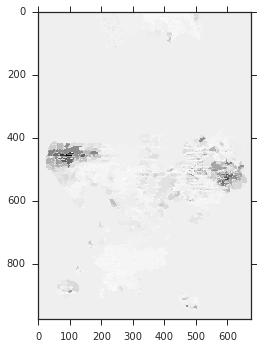

In [146]:
Masktemp=Mask.astype(np.float32).copy()
for idx in xrange(0,corrMat.shape[0]):
    Masktemp[Masktemp==idx+1]=corrMat[idx]
fig = figure(dpi=300)
plt.imshow(Masktemp)

In [3]:
aud8freq=np.zeros((8,700),dtype=np.int);
aud8freq[0,21:21+5]=1;
aud8freq[0,406:406+5]=1;
aud8freq[0,611:611+5]=1;

aud8freq[1,46:46+5]=1;
aud8freq[1,381:381+5]=1;
aud8freq[1,536:536+5]=1;

aud8freq[2,71:71+5]=1;
aud8freq[2,356:356+5]=1;
aud8freq[2,511:511+5]=1;

aud8freq[3,96:96+5]=1;
aud8freq[3,331:251];
aud8freq[3,561:561+5]=1;

aud8freq[4,121:121+5]=1;
aud8freq[4,306:306+5]=1;
aud8freq[4,486:486+5]=1;

aud8freq[5,146:146+5]=1;
aud8freq[5,281:281+5]=1;
aud8freq[5,586:586+5]=1;

aud8freq[6,171:171+5]=1;
aud8freq[6,256:256+5]=1;
aud8freq[6,461:461+5]=1;

aud8freq[7,196:196+5]=1;
aud8freq[7,231:231+5]=1;
aud8freq[7,636:636+5]=1;

In [97]:
combination[0].shape

(700,)

In [39]:
ccr=[]
result=[]
pvalues=[]
for j in range(1,aud8freq.shape[0]):
    cc,pval=pearsonr(aud8freq[0],aud8freq[j])
    ccr.append(cc)
    pvalues.append(pval)
result.append(ccr)
result.append(pvalues)
results=[]
results.append(result)

In [30]:
ccr

[-0.020408163265306124,
 -0.020408163265306117,
 -0.016606805534831331,
 -0.020408163265306117,
 -0.020408163265306121,
 -0.020408163265306117,
 -0.020408163265306117]

In [31]:
np.argmax(ccr)

2

In [33]:
results=[]
results.append(ccr)
results.append(pvalues)

In [40]:
results[1]

IndexError: list index out of range

In [41]:
for data_slice in results:
    print data_slice

[[-0.020408163265306124, -0.020408163265306117, -0.016606805534831331, -0.020408163265306117, -0.020408163265306121, -0.020408163265306117, -0.020408163265306117], [0.57682630922172362, 0.57682630922172362, 0.64977928203050206, 0.57682630922172362, 0.57682630922172362, 0.57682630922172362, 0.57682630922172362]]


In [44]:
data_slice[1]

[0.57682630922172362,
 0.57682630922172362,
 0.64977928203050206,
 0.57682630922172362,
 0.57682630922172362,
 0.57682630922172362,
 0.57682630922172362]

In [45]:
data_to_analyze=tsc.loadSeries('/mnt/downloads/'+directory+'/nhatFullData.npy', inputFormat='npy', minPartitions=300)

In [49]:
corrs = data_to_analyze.correlate(aud8freq[0])
corrMat = corrs.collectasarray()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 3.0 failed 1 times, most recent failure: Lost task 7.0 in stage 3.0 (TID 309, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/pyspark/rdd.py", line 2355, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 2355, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/series.py", line 89, in <lambda>
    d = self.rdd.keys().mapPartitions(lambda i: [Dimensions(i, n)]).reduce(lambda x, y: x.mergeDims(y))
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/keys.py", line 14, in __init__
    self.merge(v)
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/keys.py", line 17, in merge
    self.min = tuple(map(min, self.min, value))
TypeError: argument 3 to map() must support iteration

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1283)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1271)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1270)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1270)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1496)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1458)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1447)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1822)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1835)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1848)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1919)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:905)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:904)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/pyspark/rdd.py", line 2355, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 2355, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/series.py", line 89, in <lambda>
    d = self.rdd.keys().mapPartitions(lambda i: [Dimensions(i, n)]).reduce(lambda x, y: x.mergeDims(y))
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/keys.py", line 14, in __init__
    self.merge(v)
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/keys.py", line 17, in merge
    self.min = tuple(map(min, self.min, value))
TypeError: argument 3 to map() must support iteration

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


In [52]:
corrMat = corrs.collectAsArray()

In [61]:
corrMat = corrs.collectValuesAsArray()
corrMat.shape

(4229,)

In [63]:
corrMat.shape[0]

4229

In [65]:
corrMat[4000]

-0.03103714828483603